# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

### Pressure Swing Distillation

Separation of the Methanol and Acetone minimum temperature azeotrope by using the pressure sensitivity of the azeotropic composition of this mixture by operating two columns at different pressures, adapted from [Luyben et al. Ind.Eng.Chem.Res. (2008) 47 pp. 2696-2707.](http://pubs.acs.org/doi/pdf/10.1021/ie701695u).

The number of stages in this flowsheet differs from the specifications used in the ChemSep example.

[Link to the flowsheet drawing](http://www.chemsep.org/downloads/data/Pressure_Swing_MA_iecr47p2696.png)

In this advanced version of the example we will use sensitivity analysis to find the effect of different pressure levels in the columns.

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

# Set up Thermodynamics

In [5]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Acetone"))
sys.AddComponent(Database.FindComponent("Methanol"))
Database.FillBIPs(sys)

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

# Analysis of the Thermo System

In [6]:
def xyplots():
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    numSteps=20    
    mixture= MaterialStream("Mix", sys)
    mixture.Specify("VF",0.0)
    mixture.Specify("P",1000, METRIC.mbar)
    for c in names:
        mixture.Specify("n["+c+"]",1.0)
    mixture.InitializeFromMolarFlows()
    mixture.FlashPZ()

    test= Flowsheet("test")
    test.AddMaterialStream(mixture)

    solver= num.DecompositionSolver(logger)
    result=solver.Solve(test)
    fig,ax=plt.subplots(1,1,figsize=(12,12))
    plist=np.linspace(1000,10000,5);
    for p in plist:
        xvec=[]
        yvec=[]
        mixture.Specify("P",p, METRIC.mbar)
        for c in range(numSteps):
            for k in range(numComps):                    
                mixture.Specify("n["+names[k]+"]",0.0)
            mixture.Specify("n["+names[0]+"]",c/(numSteps-1))
            mixture.Specify("n["+names[1]+"]",1.0-c/(numSteps-1))
            mixture.InitializeFromMolarFlows()
            mixture.FlashPZ()
            solver.Solve(test)                               
            xvec.append(mixture.GetVariable('xL['+names[0]+']').Val())               
            yvec.append(mixture.GetVariable('xV['+names[0]+']').Val())               
        ax.plot(xvec, yvec)           
        ax.set_xlabel('$x_{'+names[0]+'}$')       
        ax.set_ylabel('$y_{'+names[0]+'}$')
        ax.set_aspect('equal', 'box')
    ax.plot(xvec, xvec, color="k")  
    
    ax.legend(['{:.0f} bar'.format(x) for x in plist])  
    logger.Flush()
    plt.title('(x,y)-Diagram of Acetone/Methnanol');

In [7]:
def Txplots():   
    numSteps=21
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    mixtureBubble= MaterialStream("MixB", sys)
    mixtureBubble.Specify("VF",0.0)
    mixtureBubble.Specify("P",1000, METRIC.mbar)
    for c in names:
        mixtureBubble.Specify("n["+c+"]",1.0)
    mixtureBubble.InitializeFromMolarFlows()
    mixtureBubble.FlashPZ()

    mixtureDew= MaterialStream("MixB", sys)
    mixtureDew.Specify("VF",1.0)
    mixtureDew.Specify("P",1000, METRIC.mbar)
    for c in names:
        mixtureDew.Specify("n["+c+"]",1.0)
    mixtureDew.InitializeFromMolarFlows()
    mixtureDew.FlashPZ()
    
    flowTx= Flowsheet("Txplot")
    flowTx.AddMaterialStreams(mixtureBubble, mixtureDew)
    solver= num.DecompositionSolver(logger)
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    plist=np.linspace(1000,10000,9);
    col=0
    for p in plist:
        xvec=[]
        yvec=[]
        yvec2=[]
        i=0
        j=1
        mixtureBubble.Specify("P",p, METRIC.mbar)
        mixtureDew.Specify("P",p, METRIC.mbar)
        for c in range(numSteps):
            for k in range(numComps):                    
                mixtureBubble.Specify("n["+names[k]+"]",0.0)
                mixtureDew.Specify("n["+names[k]+"]",0.0)
            mixtureBubble.Specify("n["+names[i]+"]",c/(numSteps-1))
            mixtureBubble.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
            mixtureBubble.InitializeFromMolarFlows()
            mixtureBubble.FlashPZ()
            mixtureDew.Specify("n["+names[i]+"]",c/(numSteps-1))
            mixtureDew.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
            mixtureDew.InitializeFromMolarFlows()
            mixtureDew.FlashPZ()
            solver.Solve(flowTx)                               
            xvec.append(mixtureBubble.GetVariable('x['+names[i]+']').Val())               
            yvec.append(mixtureBubble.GetVariable('T').Val()-273.15)               
            yvec2.append(mixtureDew.GetVariable('T').Val()-273.15)               
        ax.plot(xvec, yvec, color='C'+str(col))
        ax.plot(xvec, yvec2, label='_nolegend_', color='C'+str(col))                    
        ax.set_xlabel('$x_{'+names[i]+'}$')       
        ax.set_ylabel('T [°C]')
        col+=1
          
    ax.legend(['{:.0f} bar'.format(x) for x in plist])  
    plt.tight_layout()
    plt.title('(T,x)-Diagram of Acetone/Methanol');  

To demonstrate the idea behind the process, one has to show the x,y-plots for the equilibrium at the two different pressure levels. In the first column, at 1 bar, pure Methanol is drawn from the bottom, and the azeotropic mixture (75% Acetone and 25% Mathanol) at the top. In the second column, at 10 bar, pure Methanol is drawn from the bottom and the azeotrope (40% Acetone and 60% Methanol) ise drawn from the top. The azeotrope is recycled back to first column to recover the methanol.

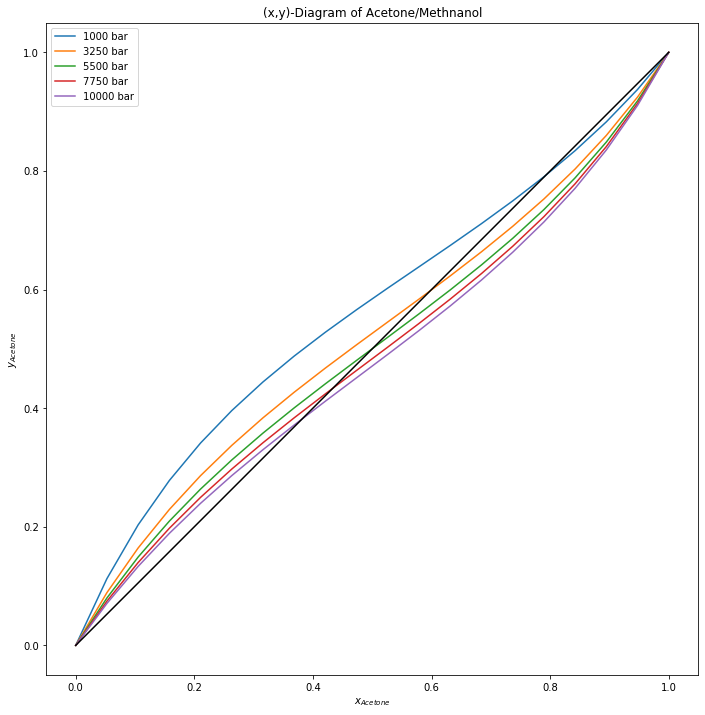

In [8]:
xyplots()

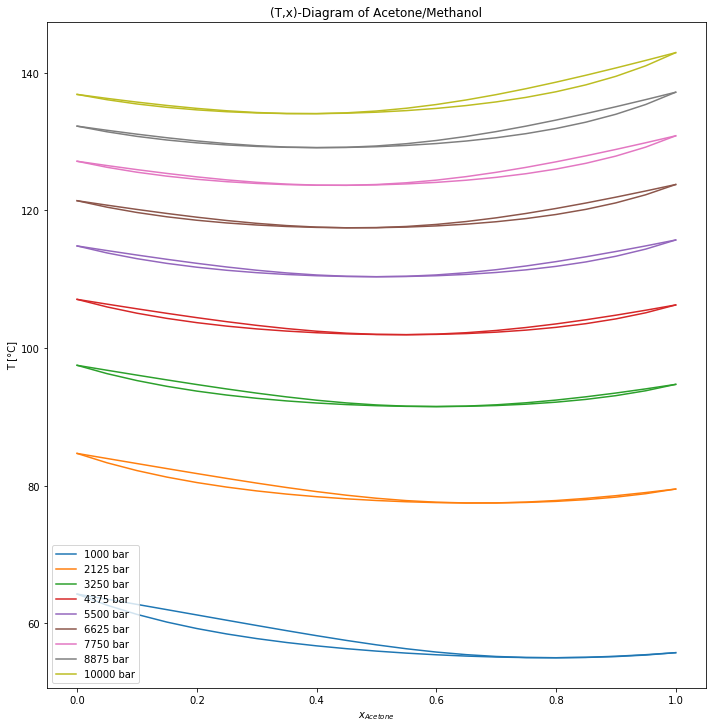

In [9]:
Txplots()

# Low pressure column

In [10]:
Feed = (MaterialStream("Feed", sys)
    .Specify("T",43, METRIC.C)
    .Specify("P",1, METRIC.bar)
    .Specify("n[Acetone]", 270, kmolh)
    .Specify("n[Methanol]", 270, kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())

Recycle = (MaterialStream("Recycle", sys)
    .Specify("T",54, METRIC.C)
    .Specify("P",10, METRIC.bar)
    .Specify("n[Acetone]",10, kmolh)
    .Specify("n[Methanol]", 170, kmolh)
    .InitializeFromMolarFlows()
    .FlashPZ())

S01 = MaterialStream("S01", sys)
S02 = MaterialStream("S02", sys)
S03 =(MaterialStream("S03", sys)
    .Init("T", 51, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",50, kmolh)
    .Init("n[Methanol]", 50, kmolh))

S04 = MaterialStream("S04", sys)
S05 = (MaterialStream("S05", sys)
    .Init("T", 61, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",2, kmolh)
    .Init("n[Methanol]", 100, kmolh))

Methanol = MaterialStream("Methanol", sys)
D1 = MaterialStream("D1", sys)

In [11]:
C1 = (EquilibriumStageSection("C1",sys,52)
        .Connect("VIn", S05)
        .Connect("LIn", S03)
        .Connect("VOut", S01)
        .Connect("LOut", S04)
        .ConnectFeed(Feed,37)
        .ConnectFeed(Recycle,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(2.3,0.25,logger))

REB1 =(Flash("REB1",sys)
        .Connect("In", S04)
        .Connect("Vap", S05)
        .Connect("Liq", Methanol)
        .Specify("P", 1, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND1 = (Heater("COND1",sys)
        .Connect("In", S01)
        .Connect("Out", S02)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio1=2.36
REFSPL1 = (Splitter("REFSPL1",sys)
        .Connect("In", S02)
        .Connect("Out1", S03)
        .Connect("Out2", D1)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",RefluxRatio1/(1.0+RefluxRatio1))
        .Initialize())

C1.Initialize(1.0,0.25,logger)
logger.Flush();

In [12]:
flowsheet= (Flowsheet("Flow")
            .AddMaterialStreams(Feed, Recycle, S01,S02,S03,D1,S04,S05, Methanol)
            .AddUnits(C1, REB1, COND1, REFSPL1))

In [13]:
solver= num.DecompositionSolver(logger)

solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=740, E=740, Blocks=140, Singletons=128
Block Statistics:
   # Var # Blocks % Blocks
       1      128  91,43 %
       3        4   2,86 %
       5        4   2,86 %
       6        3   2,14 %
     562        1   0,71 %
Problem NLAES was successfully solved (0,31 seconds)



In [14]:
reporter.Report(flowsheet, 5, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              43.0000     136.0140      55.0442      55.0345      55.0345
Pressure                  bar              1.0000      10.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -23755.2480    2085.9629  -29148.4951  -29148.4951
Phase                                      Liquid  LiquidVapor        Vapor  BubblePoint  LiquidVapor

Total Molar Flow          kmol/h         540.0000     180.0000    1067.7375    1067.7375     749.9585
                  Acetone kmol/h         270.0000      10.0000     809.6312     809.6312     568.6696
                 Methanol kmol/h         270.0000     170.0000     258.1063     258.1063     181.

# Add High pressure column

In [15]:
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = (MaterialStream("S08", sys)
        .Init("T", 54, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",50, kmolh)
        .Init("n[Methanol]", 50, kmolh))

S09 = MaterialStream("S09", sys)

S10 = (MaterialStream("S10", sys)
        .Init("T", 140, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",100, kmolh)
        .Init("n[Methanol]", 2, kmolh))

Acetone = MaterialStream("Acetone", sys)
D2 = MaterialStream("D2", sys)

C2 = (EquilibriumStageSection("C2",sys,61)
        .Connect("VIn", S10)
        .Connect("LIn", S08)
        .Connect("VOut", S06)
        .Connect("LOut", S09)
        .ConnectFeed(D1,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(3.11,0.1,logger))

REB2 = (Flash("REB2",sys)
        .Connect("In", S09)
        .Connect("Vap", S10)
        .Connect("Liq", Acetone)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND2 = (Heater("COND2",sys)
        .Connect("In", S06)
        .Connect("Out", S07)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio2=3.11
REFSPL2 = (Splitter("REFSPL2",sys)
        .Connect("In", S07)
        .Connect("Out1", D2)
        .Connect("Out2", S08)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",1-RefluxRatio2/(1.0+RefluxRatio2))
        .Initialize())

C2.Solve()
REB2.Solve()
COND2.Solve()
REFSPL2.Solve()
C2.Initialize(3.11,0.1,logger)
logger.Flush();

In [16]:
flowsheet.AddMaterialStreams(S06,S07,S08,D2,S09,S10,Acetone)
flowsheet.AddUnits(C2, REB2, COND2, REFSPL2);

In [17]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1547, E=1547, Blocks=269, Singletons=249
Block Statistics:
   # Var # Blocks % Blocks
       1      249  92,57 %
       3        6   2,23 %
       5        6   2,23 %
       6        6   2,23 %
     562        1   0,37 %
     652        1   0,37 %
Problem NLAES was successfully solved (0,26 seconds)



# Close Recycle

The stream recycle was fixed while we performed the startup calculations. Now we connect the recycle stream with the distillate stream of C2 to close the loop. We use a simple adiabatic heater to close the mass and energy balance.

In [18]:
Recycle.Unfix()

RECY01 = (Heater("RECY01",sys)
    .Connect("In", D2)
    .Connect("Out", Recycle)
    .Specify("DP",9, METRIC.bar)
    .Specify("Q",0, SI.kW)
    .Initialize()
    .Solve())

flowsheet.AddUnit(RECY01);

In [19]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1554, E=1554, Blocks=254, Singletons=238
Block Statistics:
   # Var # Blocks % Blocks
       1      238  93,70 %
       3        3   1,18 %
       5        5   1,97 %
       6        7   2,76 %
    1240        1   0,39 %
Problem NLAES was successfully solved (0,35 seconds)



# Reach Specifications

In [20]:
REB1.Unspecify("VF")
REB2.Unspecify("VF")
Methanol.GetVariable("x[Methanol]").Fix(0.98)
Acetone.GetVariable("x[Acetone]").Fix(0.98)

In [21]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1554, E=1554, Blocks=268, Singletons=246
Block Statistics:
   # Var # Blocks % Blocks
       1      246  91,79 %
       3        7   2,61 %
       5        7   2,61 %
       6        7   2,61 %
    1210        1   0,37 %
Problem NLAES was successfully solved (0,43 seconds)



In [22]:
reporter.Report(flowsheet, 6, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03           D1

Temperature               °C              43.0000      57.0196      55.0432      55.0339      55.0339      55.0339
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3318       1.0000       0.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20558.5183    2086.5432  -29143.6118  -29143.6118  -29143.6118
Phase                                      Liquid  LiquidVapor  LiquidVapor  BubblePoint  LiquidVapor       Liquid

Total Molar Flow          kmol/h         540.0000     171.3069    1482.7910    1482.7910    1041.4842     441.3069
                  Acetone kmol/h         270.0000      70.3284    1125.3595    1125.3595     790.4311     33

# Overall Mass Balance

For reporting purposes, we create a temporary flowsheet that collects the main process streams. This flowsheet will not be solved, but is used by the reporter object.

In [23]:
summary= Flowsheet("Summary").AddMaterialStreams(Feed, Recycle, Acetone, Methanol,D1,D2)

reporter.Report(summary, 4, False)
print (logger.Flush())            


Report for flowsheet Summary

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle      Acetone     Methanol

Temperature               °C              43.0000      57.0196     142.1128      63.5868
Pressure                  bar              1.0000       1.0000      10.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3318       0.0001       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20558.5183  -13479.0077  -33585.9760
Phase                                      Liquid  LiquidVapor  LiquidVapor  LiquidVapor

Total Molar Flow          kmol/h         540.0000     171.3069     270.0000     270.0000
                  Acetone kmol/h         270.0000      70.3284     264.6000       5.4000
                 Methanol kmol/h         270.0000     100.9784       5.4000     264.6000
Molar Composition                    
                  Acetone mol/mol          0.5000       0.4105       0.

# Temperature Profiles

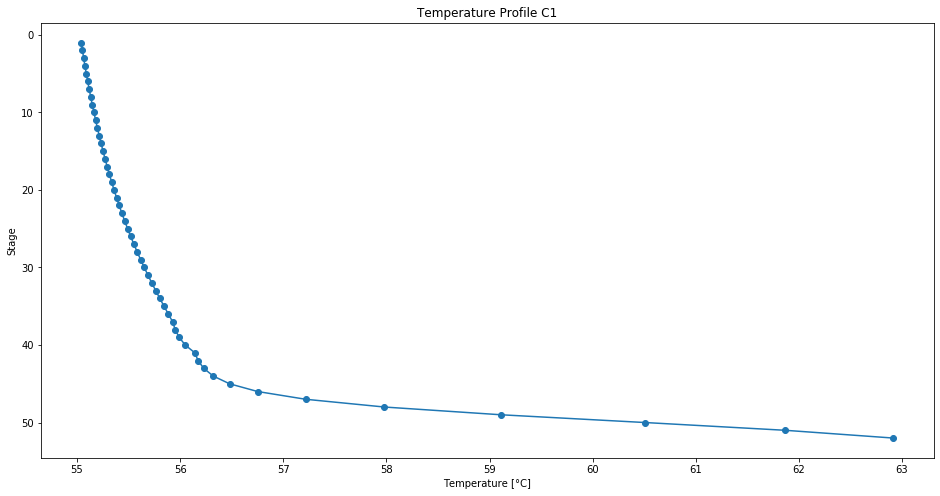

In [24]:
tprof=C1.GetProfile("T")
stages= range(1, C1.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C1");


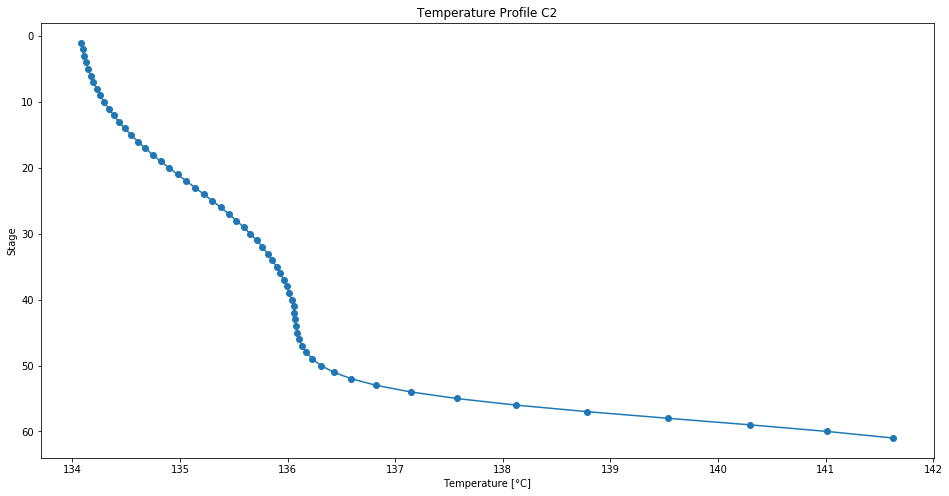

In [25]:
tprof=C2.GetProfile("T")
stages= range(1, C2.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C2");

# Sensitivity Analysis
<div style="width:100%;height:6px;background-color:Black;"></div>

In [26]:
def calc(flowsheet, relax, maxIter,showLog):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    status=presolver.Solve(flowsheet)
    if(showLog):
        print (logger.Flush())
    else:
        logger.Flush()
    return status

In [27]:
%%time
p1interval=[1.0, 3.0]
p2interval=[9, 12]
results={"P1":[],
         "P2":[],
         "QC1":[],
         "QR1":[],
         "QC2":[],
         "QR2":[],
         "Status":[],
         "Case":[],
        }

steps=6
case=1
for i in np.linspace(p1interval[0],p1interval[1],steps):
    for j in np.linspace(p2interval[0],p2interval[1],steps):
        REB1.Specify("P", i, METRIC.bar)
        COND1.Specify("P", i, METRIC.bar)
        REB2.Specify("P", j, METRIC.bar)
        COND2.Specify("P", j, METRIC.bar)
        RECY01.Specify("DP", j-i, METRIC.bar)  
        REB1.GetVariable("VF").IsFixed=True
        REB1.Initialize()
        REB1.Unspecify("VF")
        REB2.GetVariable("VF").IsFixed=True
        REB2.Initialize()
        REB2.Unspecify("VF")
        COND1.Initialize()
        COND2.Initialize()
        RECY01.Initialize()        
        status=calc(flowsheet,0.10,5,False)                
        status=solver.Solve(flowsheet)
        if(not status):
            status=calc(flowsheet,1,20,True)        
            #status=solver.Solve(flowsheet)
        logger.Flush()
        results["P1"].append(i)
        results["P2"].append(j)
        results["QC1"].append(COND1.GetVariable("Q").DisplayValue)
        results["QR1"].append(REB1.GetVariable("Q").DisplayValue)
        results["QC2"].append(COND2.GetVariable("Q").DisplayValue)
        results["QR2"].append(REB2.GetVariable("Q").DisplayValue)
        results["Status"].append(status)
        results["Case"].append(case)
        case+=1

df_sens= pd.DataFrame(results, index=results["Case"], columns=["P1","P2","QC1","QR1","QC2","QR2","Status","Case"] )
df_sens    

Wall time: 32.9 s


,P1,P2,QC1,QR1,QC2,QR2,Status,Case
1,1.0,9.0,-13.173426,12.936755,-5.749220,7.262472,True,1
2,1.0,9.6,-13.164609,12.928498,-5.742076,7.254256,True,2
3,1.0,10.2,-12.838155,12.603110,-5.338480,6.918382,True,3
4,1.0,10.8,-12.829151,12.594496,-5.331517,6.910249,True,4
5,1.0,11.4,-12.563257,12.328879,-5.001022,6.644118,True,5
6,1.0,12.0,-12.342245,12.107253,-4.724395,6.429101,True,6
7,1.4,9.0,-13.115432,12.882493,-5.703168,7.209358,True,7
8,1.4,9.6,-13.104313,12.872029,-5.694649,7.199467,True,8
9,1.4,10.2,-12.778376,12.547044,-5.293454,6.865533,True,9
10,1.4,10.8,-12.766867,12.536223,-5.285082,6.855665,True,10


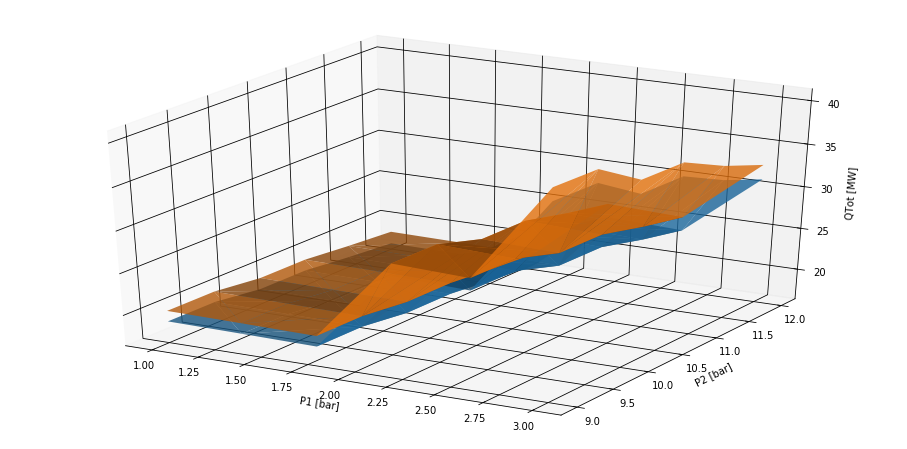

In [28]:
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_sens['P1'], df_sens['P2'], -(df_sens['QC1']+df_sens['QC2']), alpha=0.8)
ax.plot_trisurf(df_sens['P1'], df_sens['P2'], df_sens['QR1']+df_sens['QR2'], alpha=0.8)
ax.set_xlabel("P1 [bar]")
ax.set_ylabel("P2 [bar]")
ax.set_zlabel("QTot [MW]")
plt.show()